In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
import math
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
import seaborn as sns
pd.options.mode.chained_assignment = None
style.use("seaborn-whitegrid") or plt.style.use("seaborn-whitegrid")


In [2]:

iotas = [0.5, 0.6, 1]
CSs = {}

CSs['CS iota' + str(iotas[0])]  = pd.read_csv('../ModelOutputData/AgeIota05CrossSection/CS.csv')
CSs['CS iota' + str(iotas[1])]  = pd.read_csv('../ModelOutputData/AgeIota06CrossSection/CS.csv')
CSs['CS iota' + str(iotas[2])] = pd.read_csv('../ModelOutputData/AgeCtrlCrossSection/CS.csv')


In [3]:
# Read in age contours

Ages = pd.read_csv('../ModelOutputData/AgeContoursCrossSection/Age.csv')
Ages = Ages.sort_values(by=['Points:1'])

Contours = [100, 200, 400, 800, 1600, 3200, 6400]


In [4]:

add_columns = ['a_lambda1', 'a_lambda2', 'a_lambda3', 'a_ev1x', 'a_ev1y', 'a_ev1z', \
               'a_ev2x', 'a_ev2y', 'a_ev2z', 'a_ev3x', 'a_ev3y', 'a_ev3z', \
               'a_lambda1_H', 'a_lambda2_H', 'a_ev1x_H', 'a_ev1y_H', 'a_ev2x_H', 'a_ev2y_H', \
               'd_lambda1', 'd_lambda2', 'd_lambda3', 'd_ev1x', 'd_ev1y', 'd_ev1z', \
               'd_ev2x', 'd_ev2y', 'd_ev2z', 'd_ev3x', 'd_ev3y', 'd_ev3z', \
               'd_lambda1_H', 'd_lambda2_H', 'd_ev1x_H', 'd_ev1y_H', 'd_ev2x_H', 'd_ev2y_H',\
               'theta', 'w mag', 'a_lambda2 - a_lambda1', 'theta_a_d']

for i in iotas:
    for j in add_columns:
        CSs['CS iota' + str(i)][j] = np.nan


#### Points for cross-section: (0, 2910360) with tangential direction (1, 1, 0)

In [5]:

xmin, xmax = min(CSs['CS iota' + str(i)]['Points:0']), max(CSs['CS iota' + str(i)]['Points:0'])
ymin, ymax = min(CSs['CS iota' + str(i)]['Points:2']), max(CSs['CS iota' + str(i)]['Points:2'])
dist_x, dist_y = 10, 1
nx, ny = int((xmax - xmin)/dist_x + 1), int((ymax - ymin)/dist_y + 1)
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)


In [6]:

for i in iotas:
    values = CSs['CS iota' + str(i)][['a2 1', 'a2 4', 'a2 5', 'a2 4', 'a2 2', 'a2 6', \
                                  'a2 5', 'a2 6', 'a2 3']].values.reshape(-1,3)
    eigs = LA.eigh(values.reshape((-1, 3, 3)))
    CSs['CS iota' + str(i)]['a_lambda1'] = eigs[0][:,0]
    CSs['CS iota' + str(i)]['a_lambda2'] = eigs[0][:,1]
    CSs['CS iota' + str(i)]['a_lambda3'] = eigs[0][:,2]
    
    CSs['CS iota' + str(i)]['a_ev1x'] = eigs[1][:,0,0]
    CSs['CS iota' + str(i)]['a_ev1y'] = eigs[1][:,0,1]
    CSs['CS iota' + str(i)]['a_ev1z'] = eigs[1][:,0,2]
    CSs['CS iota' + str(i)]['a_ev2x'] = eigs[1][:,1,0]
    CSs['CS iota' + str(i)]['a_ev2y'] = eigs[1][:,1,1]
    CSs['CS iota' + str(i)]['a_ev2z'] = eigs[1][:,1,2]
    CSs['CS iota' + str(i)]['a_ev3x'] = eigs[1][:,2,0]
    CSs['CS iota' + str(i)]['a_ev3y'] = eigs[1][:,2,1]
    CSs['CS iota' + str(i)]['a_ev3z'] = eigs[1][:,2,2]


In [7]:
# Calculate horizontal eigenvalues and eigenvectors

for i in iotas:
    values = CSs['CS iota' + str(i)][['a2 1', 'a2 4', 'a2 4', 'a2 2']].values.reshape(-1,2)
    eigs = LA.eigh(values.reshape((-1, 2, 2)))
    CSs['CS iota' + str(i)]['a_lambda1_H'] = eigs[0][:,0]
    CSs['CS iota' + str(i)]['a_lambda2_H'] = eigs[0][:,1]
    
    CSs['CS iota' + str(i)]['a_ev1x_H'] = eigs[1][:,0,0]
    CSs['CS iota' + str(i)]['a_ev1y_H'] = eigs[1][:,0,1]
    CSs['CS iota' + str(i)]['a_ev2x_H'] = eigs[1][:,1,0]
    CSs['CS iota' + str(i)]['a_ev2y_H'] = eigs[1][:,1,1]


In [8]:

for i in iotas:
    CSs['CS iota' + str(i)]['theta'] = np.arccos(CSs['CS iota' + str(i)]['a_ev3z'])
    CSs['CS iota' + str(i)]['theta'] = np.where(CSs['CS iota' + str(i)]['theta'] < np.pi/2, \
                                            CSs['CS iota' + str(i)]['theta'], \
                                            np.pi - CSs['CS iota' + str(i)]['theta'])
    CSs['CS iota' + str(i)]['theta_deg'] = np.rad2deg(CSs['CS iota' + str(i)]['theta'])


In [9]:

for i in iotas:
    values = CSs['CS iota' + str(i)][['d 1', 'd 4', 'd 5', 'd 4', 'd 2', 'd 6', \
                                  'd 5', 'd 6', 'd 3']].values.reshape(-1,3)
    eigs = LA.eigh(values.reshape((-1, 3, 3)))
    CSs['CS iota' + str(i)]['d_lambda1'] = eigs[0][:,0]
    CSs['CS iota' + str(i)]['d_lambda2'] = eigs[0][:,1]
    CSs['CS iota' + str(i)]['d_lambda3'] = eigs[0][:,2]
    
    CSs['CS iota' + str(i)]['d_ev1x'] = eigs[1][:,0,0]
    CSs['CS iota' + str(i)]['d_ev1y'] = eigs[1][:,0,1]
    CSs['CS iota' + str(i)]['d_ev1z'] = eigs[1][:,0,2]
    CSs['CS iota' + str(i)]['d_ev2x'] = eigs[1][:,1,0]
    CSs['CS iota' + str(i)]['d_ev2y'] = eigs[1][:,1,1]
    CSs['CS iota' + str(i)]['d_ev2z'] = eigs[1][:,1,2]
    CSs['CS iota' + str(i)]['d_ev3x'] = eigs[1][:,2,0]
    CSs['CS iota' + str(i)]['d_ev3y'] = eigs[1][:,2,1]
    CSs['CS iota' + str(i)]['d_ev3z'] = eigs[1][:,2,2]
    

In [10]:

for i in iotas:
    values = CSs['CS iota' + str(i)][['d 1', 'd 4', 'd 4', 'd 2']].values.reshape(-1,2)
    eigs = LA.eigh(values.reshape((-1, 2, 2)))
    CSs['CS iota' + str(i)]['d_lambda1_H'] = eigs[0][:,0]
    CSs['CS iota' + str(i)]['d_lambda2_H'] = eigs[0][:,1]
    
    CSs['CS iota' + str(i)]['d_ev1x_H'] = eigs[1][:,0,0]
    CSs['CS iota' + str(i)]['d_ev1y_H'] = eigs[1][:,0,1]
    CSs['CS iota' + str(i)]['d_ev2x_H'] = eigs[1][:,1,0]
    CSs['CS iota' + str(i)]['d_ev2y_H'] = eigs[1][:,1,1]
    

In [11]:
# Calculate the angle between the eigenvectors corresponding to the maximum horizontal anisotropy 
# eigenvector and the maximum horizontal strain rate eigenvector

for i in iotas:
    CSs['CS iota' + str(i)]['theta_a_d'] = np.arccos(CSs['CS iota' + str(i)]['a_ev2x_H'] \
                                                 * CSs['CS iota' + str(i)]['d_ev2x_H'] \
                                                 + CSs['CS iota' + str(i)]['a_ev2y_H'] \
                                                 * CSs['CS iota' + str(i)]['d_ev2y_H'])
    CSs['CS iota' + str(i)]['theta_a_d'] = np.where(CSs['CS iota' + str(i)]['theta_a_d'] < np.pi/2, \
                                                CSs['CS iota' + str(i)]['theta_a_d'], \
                                                np.pi - CSs['CS iota' + str(i)]['theta_a_d'])


In [12]:
# Calculate magnitude of the vorticity vector

for i in iotas:
    CSs['CS iota' + str(i)]['w mag'] = np.sqrt(CSs['CS iota' + str(i)]['w 1']**2 + CSs['CS iota' + str(i)]['w 2']**2 + CSs['CS iota' + str(i)]['w 3']**2)


In [13]:
# Calculate the difference between lambda1 and lambda2

for i in iotas:
    CSs['CS iota' + str(i)]['a_lambda2 - a_lambda1'] = CSs['CS iota' + str(i)]['a_lambda2'] - CSs['CS iota' + str(i)]['a_lambda1']


In [14]:
# Calculate the difference between the smaller 3D eigenvalues and the horizontal eigenvalues

for i in iotas:
    CSs['CS iota' + str(i)]['a_lambda2 - a_lambda2_H'] = CSs['CS iota' + str(i)]['a_lambda2'] - CSs['CS iota' + str(i)]['a_lambda2_H']
    CSs['CS iota' + str(i)]['a_lambda1 - a_lambda1_H'] = CSs['CS iota' + str(i)]['a_lambda1'] - CSs['CS iota' + str(i)]['a_lambda1_H']


In [15]:
# Calculate the Woodcock k number

for i in iotas:
    CSs['CS iota' + str(i)]['k'] = np.log(CSs['CS iota' + str(i)]['a_lambda3'] / CSs['CS iota' + str(i)]['a_lambda2']) \
                                      / np.log(CSs['CS iota' + str(i)]['a_lambda2'] / CSs['CS iota' + str(i)]['a_lambda1'])


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# Define dictionaries to store gridded data

axx = {}
ayy = {}
azz = {}
theta = {}
theta_a_d = {}
a_lambda1 = {}
a_lambda2 = {}
a_lambda3 = {}
a_lambda1_subtract = {}
a_lambda2_subtract = {}
k = {}
w_mag = {}
d_ev1x_H = {}
d_ev1y_H = {}
d_ev2x_H = {}
d_ev2y_H = {}
d_lambda1_H = {}
d_lambda2_H ={}
a_ev1x_H = {}
a_ev1y_H = {}
a_ev2x_H = {}
a_ev2y_H = {}
a_lambda1_H = {}
a_lambda2_H ={}
w1 = {}
w2 = {}
w3 = {}

for i in iotas:
    axx['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a2 1'], (grid_x, grid_y), method='linear')
    ayy['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a2 2'], (grid_x, grid_y), method='linear')
    azz['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a2 3'], (grid_x, grid_y), method='linear')
    theta['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['theta'], (grid_x, grid_y), method='linear')
    theta_a_d['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['theta_a_d'], (grid_x, grid_y), method='linear')
    a_lambda1['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_lambda1'], (grid_x, grid_y), method='linear')
    a_lambda2['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_lambda2'], (grid_x, grid_y), method='linear')
    a_lambda3['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_lambda3'], (grid_x, grid_y), method='linear')
    a_lambda1_subtract['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_lambda1 - a_lambda1_H'], (grid_x, grid_y), method='linear')
    a_lambda2_subtract['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_lambda2 - a_lambda2_H'], (grid_x, grid_y), method='linear')
    k['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['k'], (grid_x, grid_y), method='linear')
    w_mag['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['w mag'], (grid_x, grid_y), method='linear')
    d_ev1x_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['d_ev1x_H'], (grid_x, grid_y), method='linear')
    d_ev1y_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['d_ev1y_H'], (grid_x, grid_y), method='linear')
    d_ev2x_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['d_ev2x_H'], (grid_x, grid_y), method='linear')
    d_ev2y_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['d_ev2y_H'], (grid_x, grid_y), method='linear')
    d_lambda1_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['d_lambda1_H'], (grid_x, grid_y), method='linear')
    d_lambda2_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['d_lambda2_H'], (grid_x, grid_y), method='linear')
    a_ev1x_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_ev1x_H'], (grid_x, grid_y), method='linear')
    a_ev1y_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_ev1y_H'], (grid_x, grid_y), method='linear')
    a_ev2x_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_ev2x_H'], (grid_x, grid_y), method='linear')
    a_ev2y_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_ev2y_H'], (grid_x, grid_y), method='linear')
    a_lambda1_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_lambda1_H'], (grid_x, grid_y), method='linear')
    a_lambda2_H['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['a_lambda2_H'], (grid_x, grid_y), method='linear')
    w1['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['w 1'], (grid_x, grid_y), method='linear')
    w2['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['w 2'], (grid_x, grid_y), method='linear')
    w3['CS iota' + str(i)] = scipy.interpolate.griddata((CSs['CS iota' + str(i)]["Points:0"], CSs['CS iota' + str(i)]["Points:2"]), CSs['CS iota' + str(i)]['w 3'], (grid_x, grid_y), method='linear')


In [17]:

points = np.column_stack((list(CSs['CS iota' + str(i)]["Points:0"])[::], list(CSs['CS iota' + str(i)]["Points:2"])[::]))

alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]
    hull_pts[1][i] = hull_pts[1][i]
    
poly = Polygon(zip(list(hull_pts[0]), list(hull_pts[1])))
    

/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [18]:

for l in iotas:
    for i in range(len(x)):
        for j in range(len(y)):
            boolean = poly.contains(Point(x[i], y[j]))
            if boolean == False:
                axx['CS iota' + str(l)][j][i] = 'nan'
                ayy['CS iota' + str(l)][j][i] = 'nan'
                azz['CS iota' + str(l)][j][i] = 'nan'
                theta['CS iota' + str(l)][j][i] = 'nan'
                theta_a_d['CS iota' + str(l)][j][i] = 'nan'
                a_lambda1['CS iota' + str(l)][j][i] = 'nan'
                a_lambda2['CS iota' + str(l)][j][i] = 'nan'
                a_lambda3['CS iota' + str(l)][j][i] = 'nan'
                a_lambda1_subtract['CS iota' + str(l)][j][i] = 'nan'
                a_lambda2_subtract['CS iota' + str(l)][j][i] = 'nan'
                k['CS iota' + str(l)][j][i] = 'nan'
                w_mag['CS iota' + str(l)][j][i] = 'nan'
                d_ev1x_H['CS iota' + str(l)][j][i] = 'nan'
                d_ev1y_H['CS iota' + str(l)][j][i] = 'nan'
                d_ev2x_H['CS iota' + str(l)][j][i] = 'nan'
                d_ev2y_H['CS iota' + str(l)][j][i] = 'nan'
                d_lambda1_H['CS iota' + str(l)][j][i] = 'nan'
                d_lambda2_H['CS iota' + str(l)][j][i] = 'nan'
                a_ev1x_H['CS iota' + str(l)][j][i] = 'nan'
                a_ev1y_H['CS iota' + str(l)][j][i] = 'nan'
                a_ev2x_H['CS iota' + str(l)][j][i] = 'nan'
                a_ev2y_H['CS iota' + str(l)][j][i] = 'nan'
                a_lambda1_H['CS iota' + str(l)][j][i] = 'nan'
                a_lambda2_H['CS iota' + str(l)][j][i] = 'nan'
                w1['CS iota' + str(l)][j][i] = 'nan'
                w2['CS iota' + str(l)][j][i] = 'nan'
                w3['CS iota' + str(l)][j][i] = 'nan'



/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/2073145903.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])


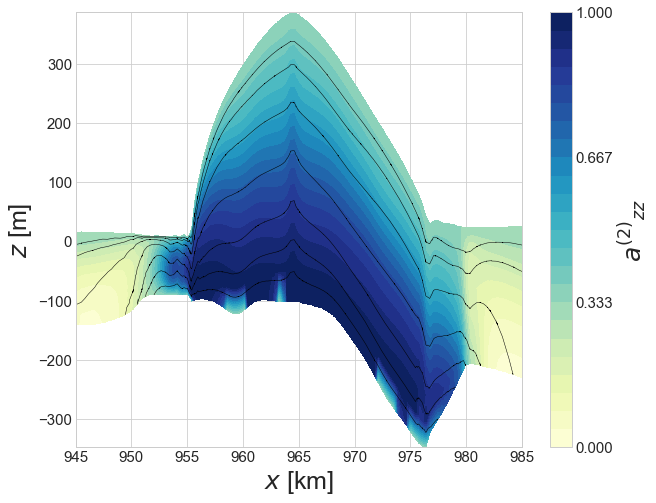

In [20]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, azz['CS iota1'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"${a^{(2)}}_{zz}$", rotation=90, size=25)
fig.savefig('../Figures/a_zz_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/746321.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, np.pi/8])


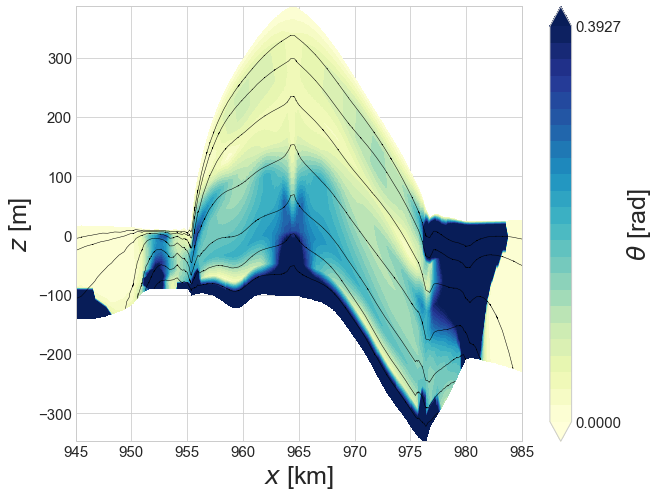

In [21]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, theta['CS iota0.5'], levels=np.linspace(0,np.pi/8,25),  cmap='YlGnBu', extend='both')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, np.pi/8])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\theta$ [rad]", rotation=90, size=25)
fig.savefig('../Figures/angle_deviation_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/4215446152.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, np.pi/8])


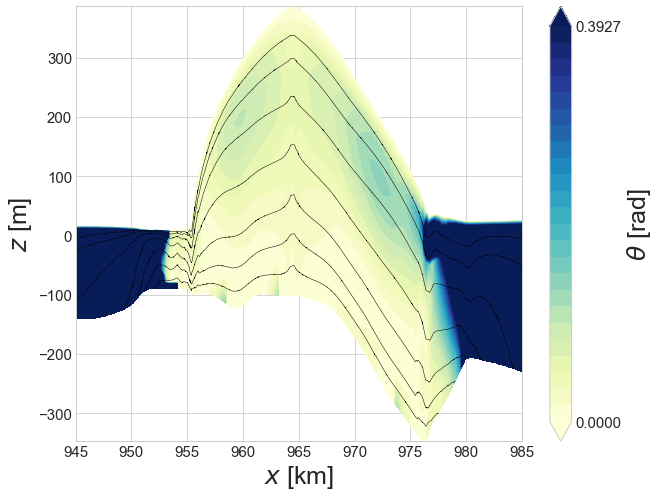

In [22]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, theta['CS iota1'], levels=np.linspace(0,np.pi/8,25),  cmap='YlGnBu', extend='both')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, np.pi/8])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\theta$ [rad]", rotation=90, size=25)
fig.savefig('../Figures/angle_deviation_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1400715632.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4, np.pi/2])


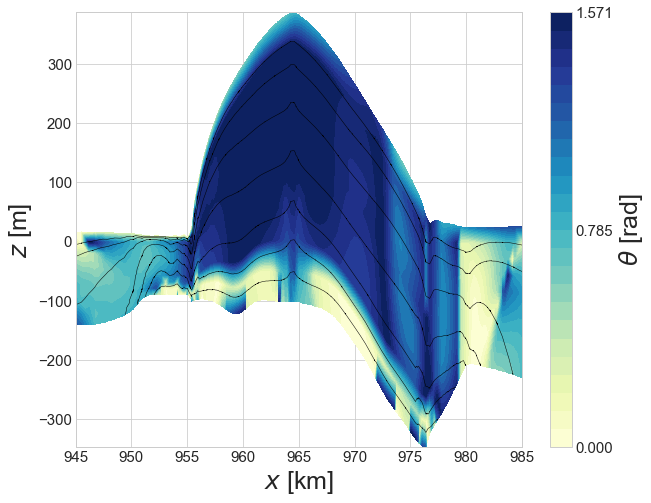

In [23]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, theta_a_d['CS iota0.5'], levels=np.linspace(0,np.pi/2,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4, np.pi/2])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\theta$ [rad]", rotation=90, size=25)
fig.savefig('../Figures/sr_aniso_angle_deviation_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1558712294.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4, np.pi/2])


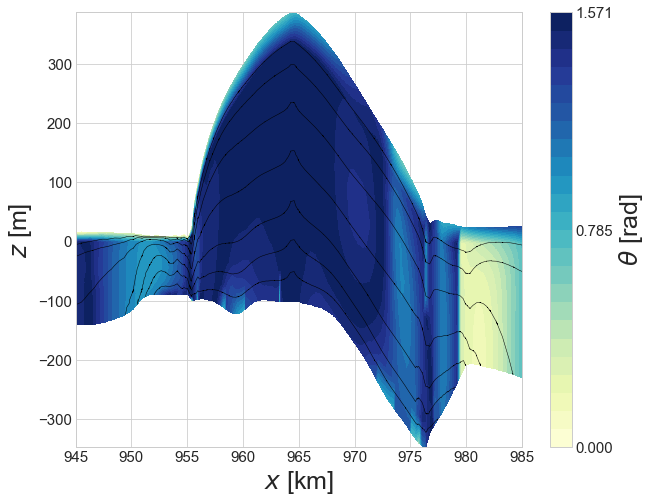

In [24]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, theta_a_d['CS iota1'], levels=np.linspace(0,np.pi/2,25), cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4, np.pi/2])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\theta$ [rad]", rotation=90, size=25)
fig.savefig('../Figures/sr_aniso_angle_deviation_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/4079937953.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])


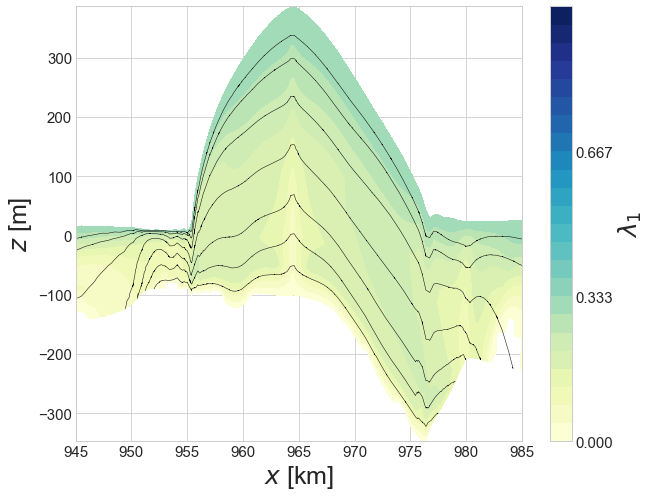

In [25]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda1['CS iota0.5'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\lambda_1$", rotation=90, size=25)
fig.savefig('../Figures/lambda1_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/3442026484.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])


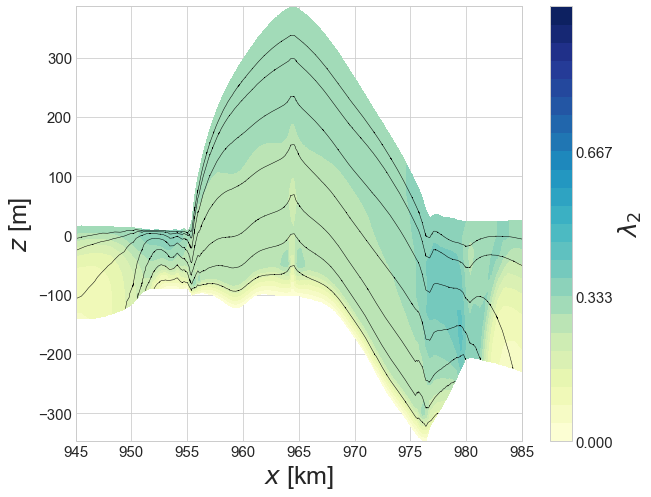

In [26]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda2['CS iota0.5'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\lambda_2$", rotation=90, size=25)
fig.savefig('../Figures/lambda2_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")
    

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/2604957606.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])


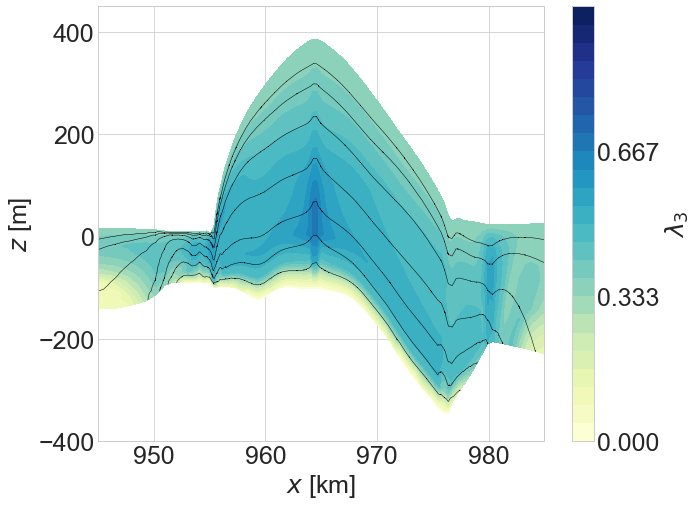

In [27]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda3['CS iota0.5'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xticks([950, 960, 970, 980])
ax.set_yticks([-400, -200, 0, 200, 400]) 
plt.xlim(945, 985)
plt.ylim(-400, 450)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\lambda_3$", rotation=90, size=25)
fig.savefig('../Figures/lambda3_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/4275489615.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])


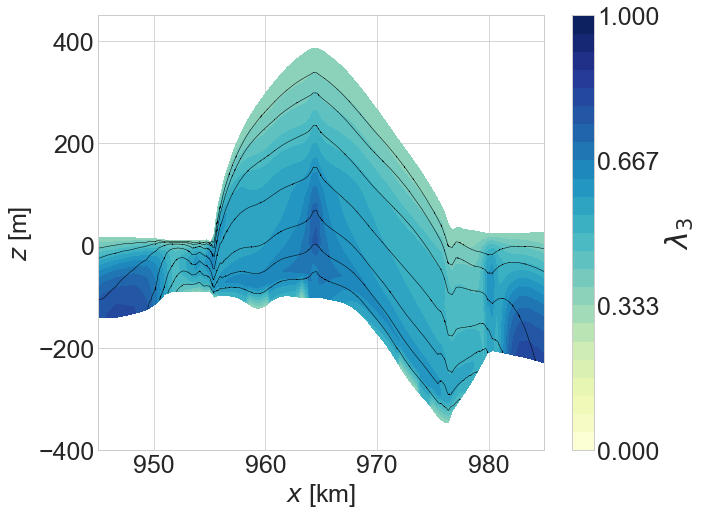

In [28]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda3['CS iota0.6'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xticks([950, 960, 970, 980])
ax.set_yticks([-400, -200, 0, 200, 400]) 
plt.xlim(945, 985)
plt.ylim(-400, 450)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\lambda_3$", rotation=90, size=30)
fig.savefig('../Figures/lambda3_Iota06.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/628736525.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])


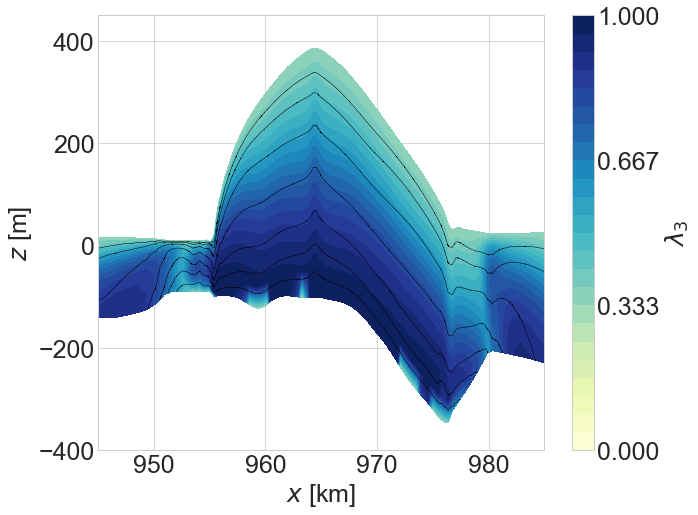

In [29]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda3['CS iota1'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xticks([950, 960, 970, 980])
ax.set_yticks([-400, -200, 0, 200, 400]) 
plt.xlim(945, 985)
plt.ylim(-400, 450)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\lambda_3$", rotation=90, size=25)
fig.savefig('../Figures/lambda3_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1473850240.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])


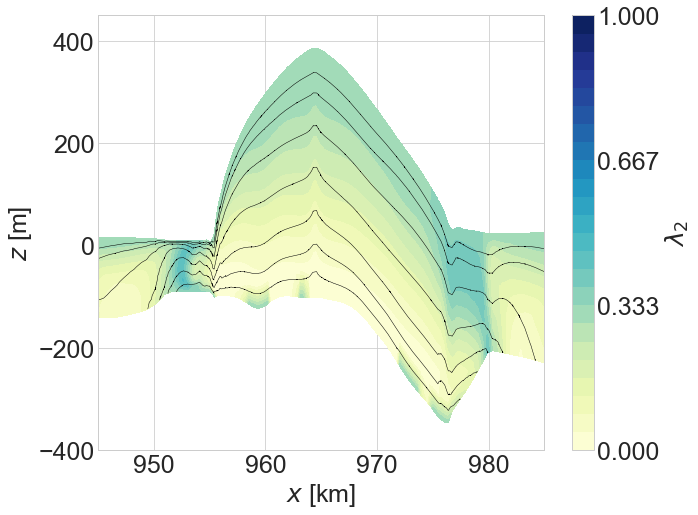

In [30]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda2['CS iota1'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xticks([950, 960, 970, 980])
ax.set_yticks([-400, -200, 0, 200, 400]) 
plt.xlim(945, 985)
plt.ylim(-400, 450)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\lambda_2$", rotation=90, size=25)
fig.savefig('../Figures/lambda2_Iota.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/962205835.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])


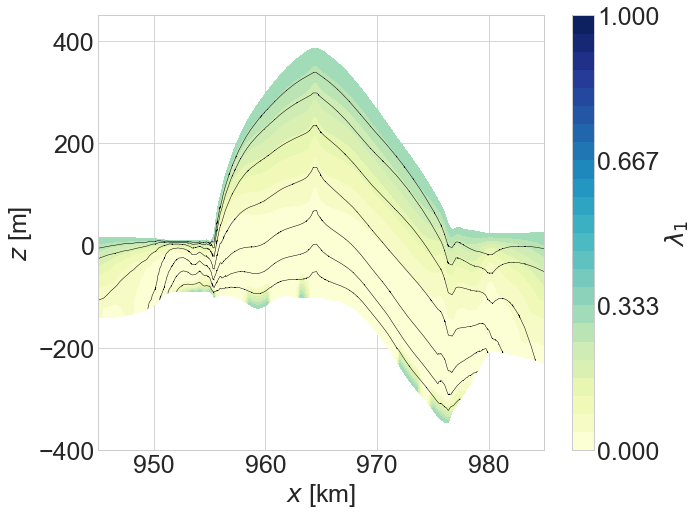

In [31]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda1['CS iota1'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xticks([950, 960, 970, 980])
ax.set_yticks([-400, -200, 0, 200, 400]) 
plt.xlim(945, 985)
plt.ylim(-400, 450)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\lambda_1$", rotation=90, size=25)
fig.savefig('../Figures/lambda1_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1895635678.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[-0.02, -0.01, 0.0, 0.01, 0.02])


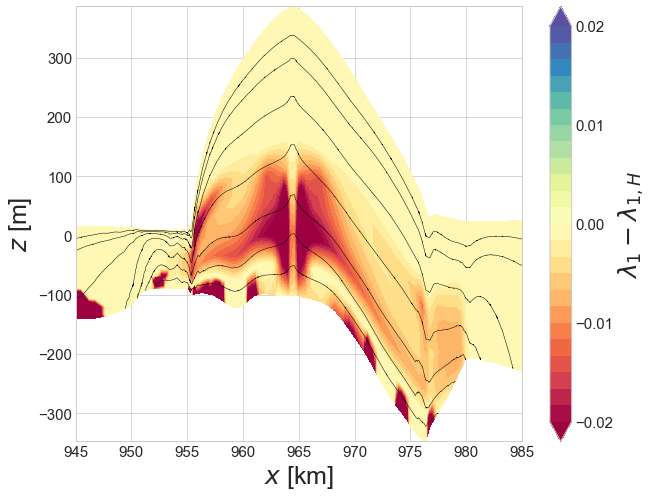

In [32]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda1_subtract['CS iota0.5'], levels=np.linspace(-0.02,0.02,25),  cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[-0.02, -0.01, 0.0, 0.01, 0.02])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\lambda_1 - \lambda_{1,H}$', rotation=90, size=25)
fig.savefig('../Figures/lambda1_diff_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1618242998.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[-0.02, -0.01, 0.0, 0.01, 0.02])


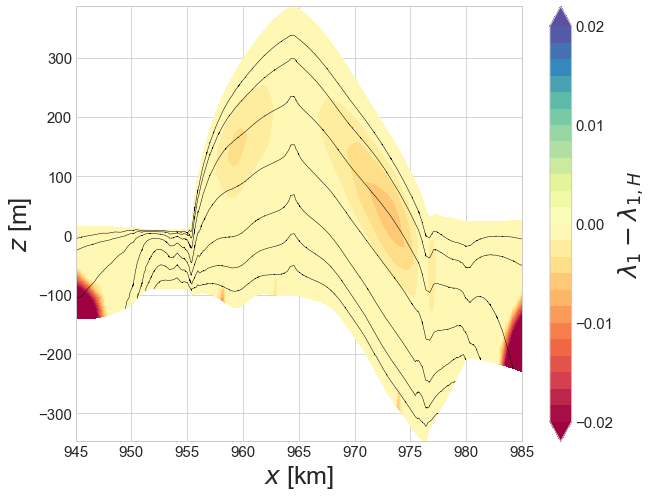

In [33]:
 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda1_subtract['CS iota1'], levels=np.linspace(-0.02,0.02,25),  cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[-0.02, -0.01, 0.0, 0.01, 0.02])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\lambda_1 - \lambda_{1,H}$', rotation=90, size=25)
fig.savefig('../Figures/lambda1_diff_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/3290665656.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[-0.02, -0.01, 0.0, 0.01, 0.02])


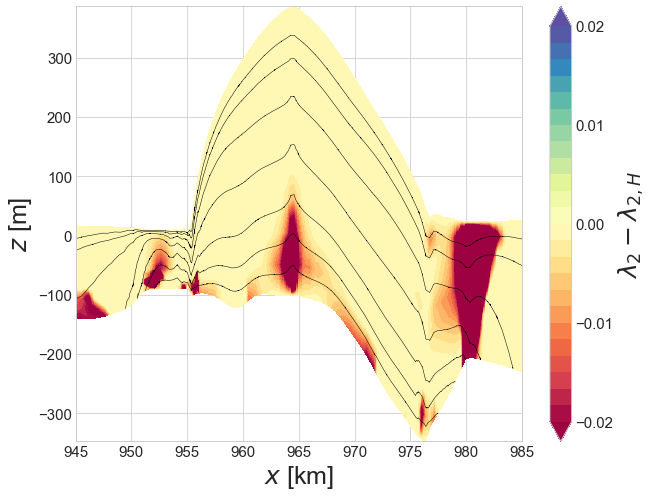

In [34]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda2_subtract['CS iota0.5'], levels=np.linspace(-0.02,0.02,25),  cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[-0.02, -0.01, 0.0, 0.01, 0.02])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\lambda_2 - \lambda_{2,H}$', rotation=90, size=25)
fig.savefig('../Figures/lambda2_diff_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/2167362140.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])


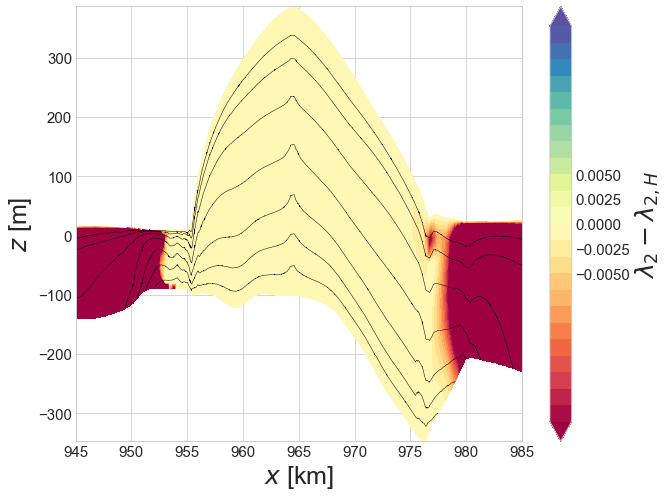

In [35]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, a_lambda2_subtract['CS iota1'], levels=np.linspace(-0.02,0.02,25),  cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\lambda_2 - \lambda_{2,H}$', rotation=90, size=25)
fig.savefig('../Figures/lambda2_diff_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/3704217195.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


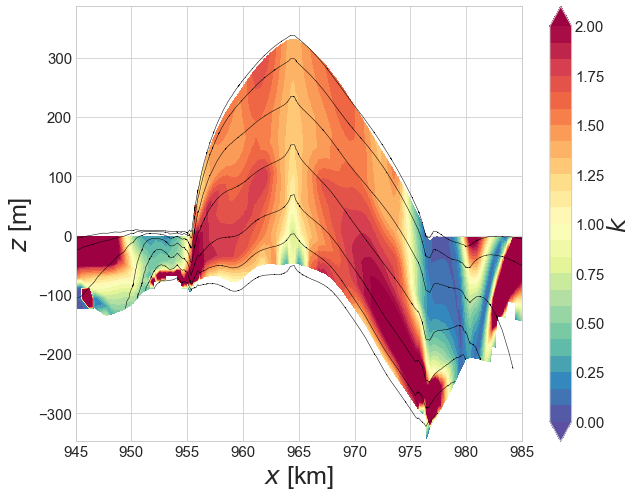

In [36]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, k['CS iota0.5'], levels=np.linspace(0,2,25),  cmap='Spectral_r', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS)
#cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$k$', rotation=90, size=25)
fig.savefig('../Figures/k_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/656305919.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


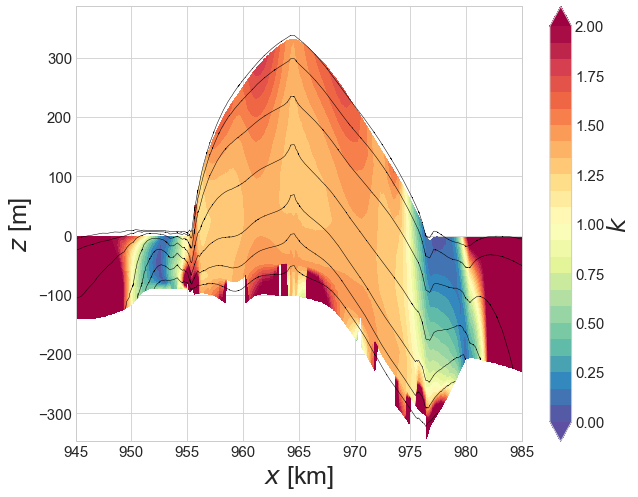

In [37]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, k['CS iota1'], levels=np.linspace(0,2,25),  cmap='Spectral_r', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
#ax.quiver(grid_x[skip]/1000, grid_y[skip], a_ev2['CS iota0.5'][skip]/1000, d_ev2y_H['CS iota0.5'][skip], pivot='mid', headlength=0, headwidth=1)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS)
#cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$k$', rotation=90, size=25)
fig.savefig('../Figures/k_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1491702052.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


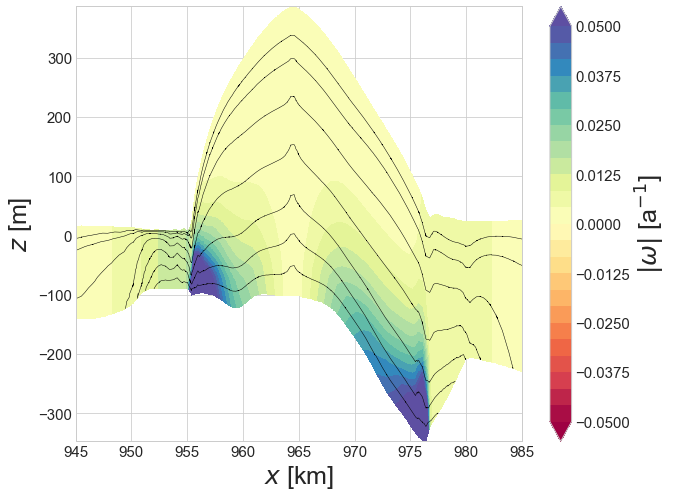

In [38]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, w_mag['CS iota0.5'], levels=np.linspace(-0.05,0.05,25),  cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS)
#cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$|\omega|$ [a$^{-1}$]', rotation=90, size=25)
fig.savefig('../Figures/w_mag_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/3516004427.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


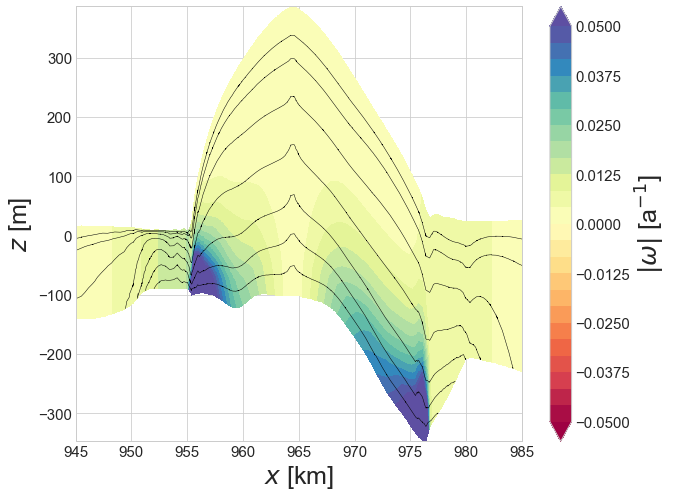

In [39]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, w_mag['CS iota1'], levels=np.linspace(-0.05,0.05,25),  cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
cbar = fig.colorbar(CS)
#cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$|\omega|$ [a$^{-1}$]', rotation=90, size=25)
fig.savefig('../Figures/w_mag_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/3228090881.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


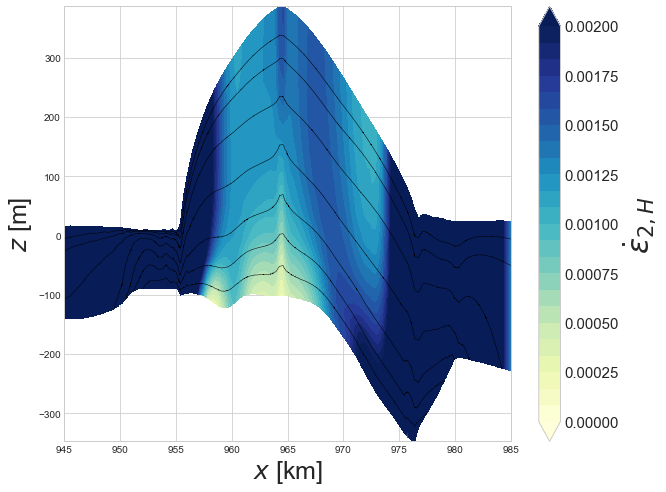

In [40]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
skip = (slice(None, None, 50), slice(None, None, 100))
CS = ax.contourf(x/1000, y, np.absolute(d_lambda2_H['CS iota0.5']), levels=np.linspace(0,0.002,25),  cmap='YlGnBu', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
#ax.quiver(grid_x[skip]/1000, grid_y[skip], d_ev2x_H['CS iota0.5'][skip]/1000, d_ev2y_H['CS iota0.5'][skip], pivot='mid', headlength=0, headwidth=1)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\dot{\varepsilon}_{2,H}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/d_lambda2_H_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/2562256648.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


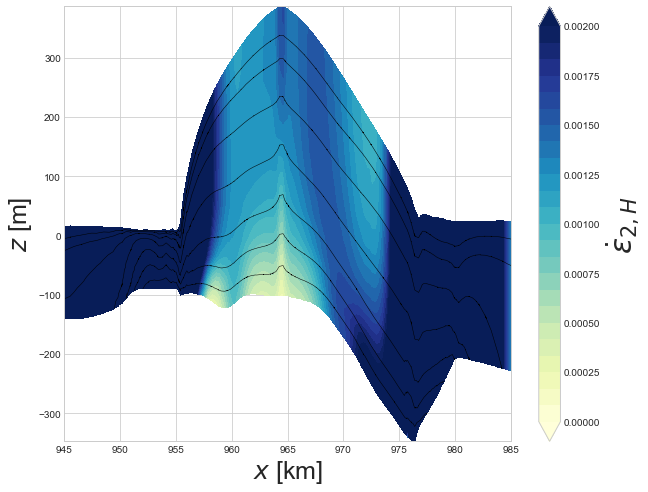

In [41]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
skip = (slice(None, None, 20), slice(None, None, 20))
CS = ax.contourf(x/1000, y, np.absolute(d_lambda2_H['CS iota1']), levels=np.linspace(0,0.002,25),  cmap='YlGnBu', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
#ax.quiver(grid_x[skip], grid_y[skip], d_ev2x_H['CS iota1'][skip], d_ev2y_H['CS iota1'][skip], pivot='mid', headlength=0, headwidth=1)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\dot{\varepsilon}_{2,H}$', size=30)
#cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/d_lambda2_H_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1589972371.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


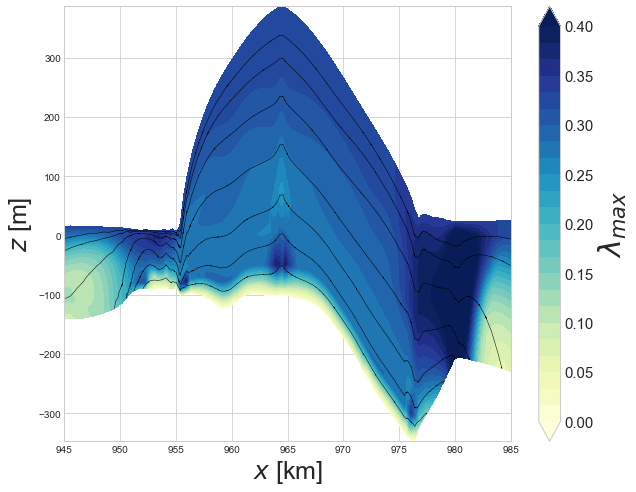

In [42]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
skip = (slice(None, None, 20), slice(None, None, 20))
CS = ax.contourf(x/1000, y, np.absolute(a_lambda2_H['CS iota0.5']), levels=np.linspace(0,0.4,25), cmap='YlGnBu', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
#ax.quiver(grid_x[skip], grid_y[skip], a_ev2x_H['CS iota0.5'][skip], a_ev2y_H['CS iota0.5'][skip], pivot='mid', headlength=0, headwidth=1)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\lambda_{max}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/a_lambda2_H_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/3430336835.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


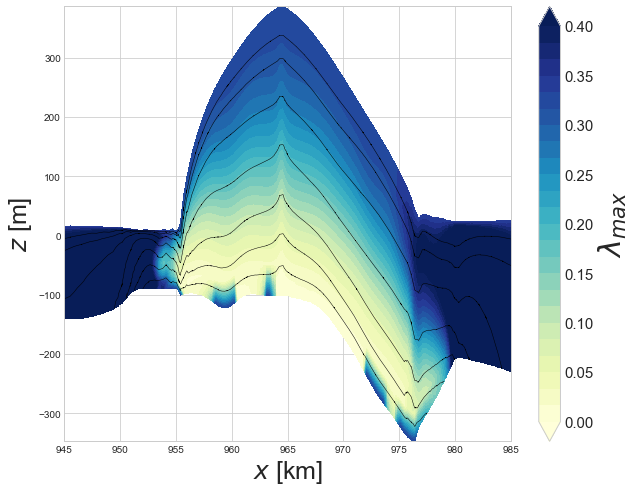

In [43]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
skip = (slice(None, None, 20), slice(None, None, 20))
CS = ax.contourf(x/1000, y, np.absolute(a_lambda2_H['CS iota1']), levels=np.linspace(0,0.4,25), cmap='YlGnBu', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
#ax.quiver(grid_x[skip], grid_y[skip], a_ev2x_H['CS iota1'][skip], a_ev2y_H['CS iota1'][skip], pivot='mid', headlength=0, headwidth=1)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\lambda_{max}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/a_lambda2_H_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/1382194296.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


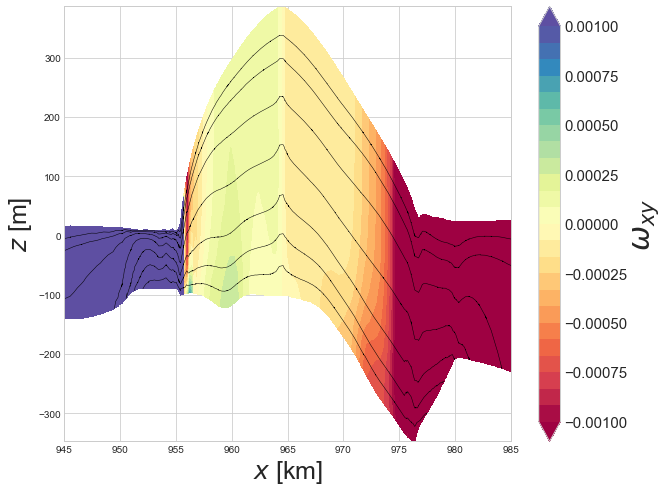

In [44]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, w1['CS iota0.5'], levels=np.linspace(-0.001,0.001,25), cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\omega_{xy}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/w1_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/3043419522.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


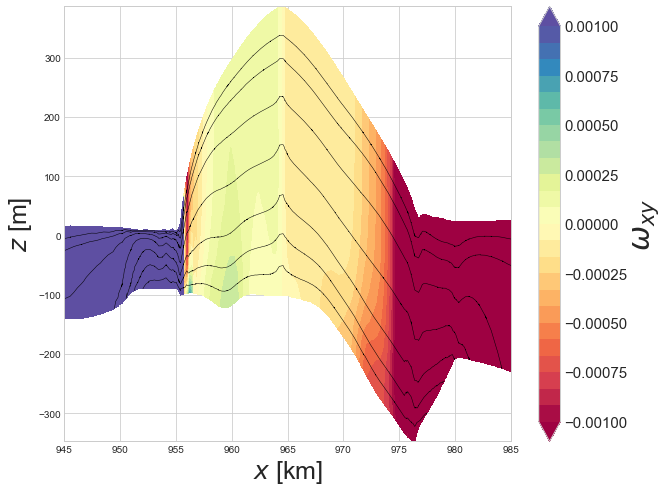

In [45]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, w1['CS iota1'], levels=np.linspace(-0.001,0.001,25), cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\omega_{xy}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/w1_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/86096857.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


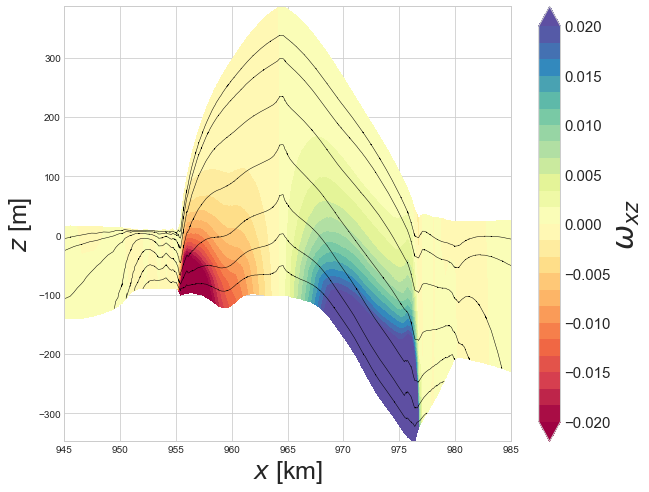

In [46]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, w2['CS iota0.5'], levels=np.linspace(-0.02,0.02,25), cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\omega_{xz}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/w2_Iota05.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_45004/2463320565.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


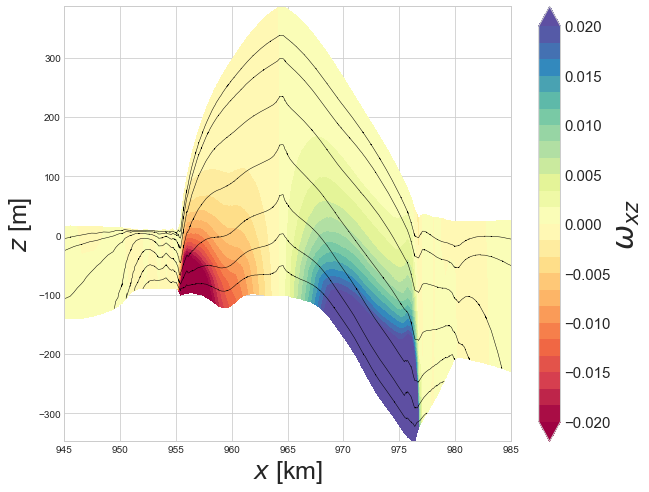

In [47]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y, w2['CS iota1'], levels=np.linspace(-0.02,0.02,25), cmap='Spectral', extend="both")
for i in Contours:
    ax.plot(Ages[Ages["age"] == i]['Points:0']/1000, Ages[Ages["age"] == i]['Points:2'], color='black', linewidth=0.5)
plt.xlim(945, 985)
#plt.ylim(1910, 1965)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$z$ [m]', size=25)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\omega_{xz}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../Figures/w2_Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")
